<a href="https://colab.research.google.com/github/patrickabadi/python-pytorch-notebooks/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Computer Vision

## 0. Computer Vision libraries in PyTorch

* torchvision
* torchvision.datasets - get datasets and data loading function
* torchvision.models - pre-trained computer vision models
* torchvisioin.transforms - functions for manipulating your vision data (images) to b suitable for use with ML model
* torch.utils.data.dataset - base dataset class for pytorch
* torch.utils.data.DataLoading - python interable over dataset

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


# 1. Getting a dataset

We're going to get the fashionMNIST dataset

In [ ]:
# setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=True,
    download=True,
    transform=ToTensor(), #how do we want to transform the data
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(), #how do we want to transform the data
    target_transform=None
)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# see the first training example
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.2 Visualizing our data

In [ ]:
image.shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Ankle boot')

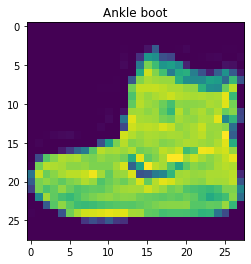

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image.squeeze())
plt.title(train_data.classes[label])

(-0.5, 27.5, 27.5, -0.5)

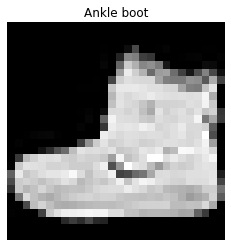

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

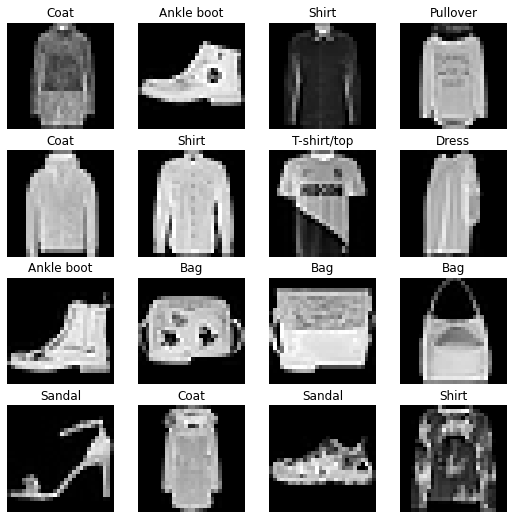

In [ ]:
# plot more images
#torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols= 4,4
for i in range(1,rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

# Do you think these items of clothing (images) could be modelled with pure linear lines or need non-linearity

from torchvision.datasets.utils import iterable_to_str
## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets

DataLoader turns our dataset into python iterable_to_str

More specifically we want to turn our data into batches (or mini-batches)

Why? 

1. It is more computationally efficient. Break down to 32 images at a time (batch size of 32)
2. It gives our neural network more changes to update it's gradients per epoch

mini batch gradient descent

In [ ]:
from torch.utils.data.dataloader import DataLoader

BATCH_SIZE = 32



train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader



(<torch.utils.data.dataloader.DataLoader at 0x7f465a04d820>,
 <torch.utils.data.dataloader.DataLoader at 0x7f465a04d7f0>)

In [ ]:
# lets check out what we've create
print(f"DataLoaders: {train_dataloader, test_dataloader}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f465a04d820>, <torch.utils.data.dataloader.DataLoader object at 0x7f465a04d7f0>)


In [ ]:
print(f"Length of train_dataLoader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataLoader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train_dataLoader: 1875 batches of 32
Length of test_dataLoader: 313 batches of 32


Image size: torch.Size([1, 28, 28])
Label: 7, label size: torch.Size([])


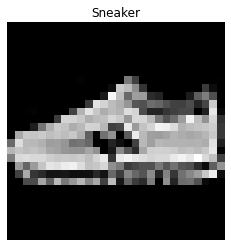

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

# show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")


## 3. Model 0: Build baseline model

when starting to build ML modeling experiments, it's best practice to start with a baseline model

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words start simply and add complexity when necessary


In [ ]:
# Create a flatten layer

flatten_model = nn.Flatten()

# get a single sample
x = train_features_batch[0]

output = flatten_model(x) #perform forward pass

print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [ ]:
from torch import nn
class FashionMNISTV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)


torch.manual_seed(42)

model_0 = FashionMNISTV0(
    input_shape=784, # this is 28x28
    hidden_units=10, # how many units in the hidden layer 
    output_shape=len(class_names) # one for every class
    ).to("cpu")

model_0

FashionMNISTV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1,1,28,28])

model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [ ]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and eval metrics

* loss function - since we're working with multiclass data loss will be nn.CrossEntropyLoss
* Optimizer - will be torch.optim.SGD
* Eval metric - since we're working on a classification problem, let's use accuracy as our eval metric

In [ ]:
import requests
from pathlib import Path

#download helper function from learnpytorch repo
if Path("helper_functions.py").is_file():
  print("file exists")
else:
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_function.py", "wb") as f:
    f.write(request.content)



In [ ]:
from helper_function import accuracy_fn

#setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


### 3.2 Creating a function to time our experiments

ML is very experimental

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time
  

In [ ]:
start_time = timer()

#some code

end_time = timer()
print_train_time(start_time,end_time, device="cpu")

Train time on cpu: 0.000 seconds


3.7696000163123244e-05

### 3.3 Creating a training loop and training a model on batches of data
1. Loop through epochs
2. loop through training batches, perform training steps, calculate the train loss *per batch*
3. loop through testing batches, perform testing steps, calculate test loss *per batch*
4. Print out what's happening
5. time it all (for fun)

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)

train_time_start_on_cpu = timer()

#set number of epochs, keep small for faster training time
epochs = 3

# create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  #### Training
  train_loss = 0

  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    #1. forward pass
    y_pred = model_0(X)

    #2. calc loss(per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss #accumulate training loss

    #3. optimizer
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    #5 optimizer step
    optimizer.step()

    if batch% 400 == 0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

  # div total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### testing
  test_loss, test_acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)

      #calc accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    
    # calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    #calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

# calculate training time
train_time_end_on_cpu = timer()

total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.04%
Epoch: 1
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.20%
Epoch: 2
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.43%
Train time on cpu: 28.082 seconds


## 4. Make predictions and get Model 0 results

In [ ]:
## 5. Setup device agnostic-code (for gpu)

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [ ]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn=accuracy_fn,
               device=device):
  """ Returns a dictionary containing the results of mode predicting on data_loader """
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):

      X,y = X.to(device), y.to(device)

      # make predictions
      y_pred = model(X)

      # accumulate the loss and acc values per batch
      loss+= loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred = y_pred.argmax(dim=1))
      
    loss/=len(data_loader)
    acc/=len(data_loader)

  return {
          "model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc
          }




In [ ]:

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn,
                             device="cpu")
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 6. Model 1: Building a better model with non-linearity

We learned about the power of non-linearity in section 2

In [ ]:
from torch.nn.modules.activation import ReLU
# create a model with non-linear and linear layers
class FashionMNISTV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten the inputs into a single vector
        nn.Linear(in_features= input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

torch.manual_seed(42)

model_1 = FashionMNISTV1(input_shape=784, #output of 28x28
                         hidden_units=10,
                         output_shape=len(class_names)).to(device)
model_1

FashionMNISTV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

# 6.1 Setup loss and optimizer

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


## 6.2 Functionizing training and evaluation loops

* training_loop - strain_step()
* test_loop - test_step()

In [ ]:
def train_step (model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device=device):
  """ Performs a training with model trying to learn on data_loader """

  #### Training
  train_loss, train_acc = 0,0

  model.train()

  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(data_loader):
    # put data on target device
    X, y = X.to(device), y.to(device)    

    #1. forward pass
    y_pred = model(X)

    #2. calc loss(per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss #accumulate training loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) #go from logits -> prediction labels

    #3. optimizer
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    #5 optimizer step
    optimizer.step()

  # div total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """ performs a testing loop step on model going over data_loader """
  test_loss, test_acc=0,0

  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      #send data to target device
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true= y,
                              y_pred = test_pred.argmax(dim=1))
      
    #adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")



In [ ]:
torch.manual_seed(42)

# measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

# create a optimization and eval loop using strain steps and test step

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}...")
  train_step(model=model_1, 
             data_loader=train_dataloader,
             loss_fn=loss_fn, 
             optimizer=optimizer, 
             accuracy_fn=accuracy_fn, 
             device=device)

  test_step(model=model_1, 
            data_loader=test_dataloader,
            loss_fn=loss_fn, 
            accuracy_fn=accuracy_fn, 
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu,
                                            train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0...
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%
Epoch 1...
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%
Epoch 2...
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%
Train time on cuda: 24.269 seconds


** Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than get_autocast_gpu_dtype
 Why is this?

 1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU
 2. The hardware you're using has a better CPU in terms of compute capability than the GPU

In [ ]:
# Get model 1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Model 2: Building a convolutional neural network (CNN)

CNN's are known as ConvNet

CNN's are known for their capabilities to find pattern in visual data

To find out what's happening see this website https://poloclub.github.io/cnn-explainer/

In [ ]:
# Create a convolutional neural network
class FashionMNISTV2(nn.Module):
  """
  Model architecture that replicate the TinyVGG
  model from CNN explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # value we can set ourselves are hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)          
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, #there's a trick to calculating this
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x



In [ ]:
torch.manual_seed(42)

model_2 = FashionMNISTV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)

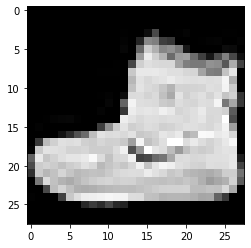

In [ ]:
plt.imshow(image.squeeze(), cmap='gray')

In [ ]:
# pass image through model
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 7.1 Stepping through 'nn.Conv2d'

In [ ]:
torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [ ]:
# create a single conv2d layer
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3,3),
                       stride=1,
                       padding=0)

# pass the data through the convolutional layer
conv_ouput = conv_layer(test_image)
conv_ouput.shape

torch.Size([10, 62, 62])

### 7.2 stepping through nn.MaxPool2d()

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [ ]:
print(f"Test image original shape: {test_image.shape}")

#create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass through just the conv layer

test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going throught the conv_layer: {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after max pool layer: {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Shape after going throught the conv_layer: torch.Size([1, 10, 62, 62])
Shape after max pool layer: torch.Size([1, 10, 31, 31])


In [ ]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1,1,2,2))
print(f"Random pool tensor: {random_tensor}")
print(f"Random pool tensor shape: {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

max_pool_tensor = max_pool_layer(random_tensor)
print(f"Max pool tensor: {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random pool tensor: tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random pool tensor shape: torch.Size([1, 1, 2, 2])
Max pool tensor: tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for model_2

In [ ]:
from helper_function import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 7.4 Training and testing 'model_2' using our training and testing functions


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#measure time
from timeit import default_timer as timer

train_time_start_model_2 = timer()

epochs=3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  
  train_time_end_model_2 = timer()

  total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                              end=train_time_end_model_2,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.59392 | Train acc: 78.55%
Test loss: 0.38435 | Test acc: 86.39%
Train time on cuda: 16.517 seconds
Epoch: 1
Train loss: 0.35511 | Train acc: 87.22%
Test loss: 0.35971 | Test acc: 86.71%
Train time on cuda: 28.601 seconds
Epoch: 2
Train loss: 0.32065 | Train acc: 88.38%
Test loss: 0.31414 | Test acc: 88.81%
Train time on cuda: 39.702 seconds


In [ ]:
# get model 2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device = device
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3141421377658844,
 'model_acc': 88.80790734824281}

## 8. Compare model results and training time


In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTV0,0.476639,83.426518
1,FashionMNISTV1,0.685001,75.019968
2,FashionMNISTV2,0.314142,88.807907


In [ ]:
# Add training time to results comparison
compare_results["training_time"]=[total_train_time_model_0, total_train_time_model_1, total_train_time_model_1]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTV0,0.476639,83.426518,28.082380
1,FashionMNISTV1,0.685001,75.019968,24.269418
2,FashionMNISTV2,0.314142,88.807907,24.269418


Text(0, 0.5, 'model')

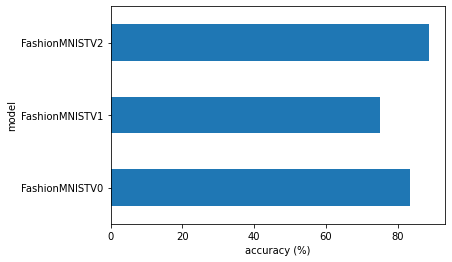

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [ ]:
!nvidia-smi

Mon Jan 30 22:02:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |   1134MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 9. Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare the sample (add a batch dimension and pass to the target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      #get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

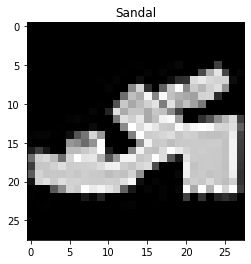

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# make some predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# view first two prediction probabilities
pred_probs[:2]

tensor([[4.9030e-08, 1.4638e-08, 3.4176e-08, 7.0050e-09, 3.0784e-09, 9.9992e-01,
         2.8847e-08, 2.2857e-06, 2.0875e-05, 5.8772e-05],
        [4.6282e-02, 8.7006e-01, 6.3767e-03, 5.0169e-02, 2.2469e-02, 8.2236e-05,
         4.0646e-03, 1.1727e-04, 5.3785e-05, 3.2009e-04]])

In [ ]:
# convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

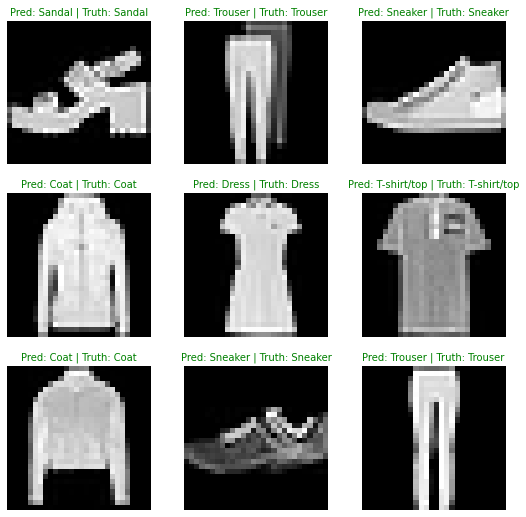

In [ ]:
# plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols=3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  # plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # find the prediction (in text form, eg. sandal)
  pred_label = class_names[pred_classes[i]]

  # truth label (in text form)
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # check for the equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c="g") # green if predication correct
  else:
    plt.title(title_text,fontsize=10, c="r")

  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your classification models

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix 'torchmetrics.ConfusionMatrix'
3. Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix()

In [ ]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc="Making predictions..."):
    # send the data and targets to target device
    X,y = X.to(device), y.to(device)

    # do the forward pass
    y_logit = model_2(X)

    # turn logit to prediction probabilities
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    # put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())\

#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [ ]:
import mlxtend

mlxtend.__version__

'0.21.0'

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlsxtedn version: {mlxtend.__version__}")

# might have to restart colab after running this just to make sure 0.19.0 is installed properly

mlxtend version 0.21.0


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))

confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

confmat_tensor

tensor([[641,   5,  46,  63,  10,   1, 227,   0,   7,   0],
        [  8, 893,   7,  72,  14,   0,   3,   0,   3,   0],
        [  9,   4, 832,  11,  79,   0,  63,   0,   2,   0],
        [ 22,   7,  23, 853,  44,   0,  45,   0,   6,   0],
        [  7,   5, 129,  36, 723,   0,  95,   0,   5,   0],
        [  2,   2,   3,   9,   0, 811,   2,  60,  87,  24],
        [ 76,   6, 121,  51,  98,   0, 638,   0,  10,   0],
        [  0,   2,   1,   0,   0,  27,   0, 914,  11,  45],
        [ 11,   2,  25,  15,  15,   5,  21,   6, 899,   1],
        [  0,   0,   1,   3,   1,  14,   5,  99,  11, 866]])

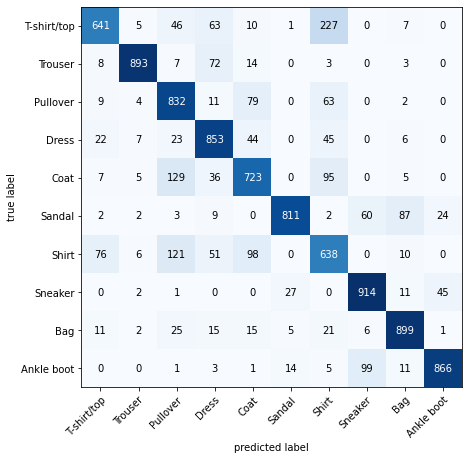

In [ ]:
# 3. Plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplot likes working with numpy
    class_names=class_names,
    figsize=(10,7)
)

## 11. Save and load best performing model

In [ ]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("models")

MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
torch.manual_seed(42)

loaded_model_2 = FashionMNISTV2(input_shape=1,
                                hidden_units=10,
                                output_shape=len(class_names))

loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

#send model to target device
loaded_model_2.to(device)


FashionMNISTV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Evaluate loaded model

torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3141421377658844,
 'model_acc': 88.80790734824281}

In [ ]:
model_2_results

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3141421377658844,
 'model_acc': 88.80790734824281}

In [ ]:
# check if model results are close to eachother
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-02)

tensor(True)